# Importing

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# Reading Data


In [11]:
drugs = pd.read_csv('/home/gustavo/github/mestrado/reworks/data/fda_approved_drugs.csv')
print(drugs.shape)
drugs.head()

(1895, 14)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,True,False,False
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,True,False,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,False,False,True,False


# Calculating 'rule-based' descriptors

In [12]:
# We wil compute a range of rule-based descriptors, that appeas in a lot of heuristics

rule_based_descriptors =  [
'exactmw',
'fractioncsp3',
'numaliphaticheterocycles',
'numaliphaticrings',
'numamidebonds',
'numaromaticheterocycles',
'numaromaticrings',
'numatomstereocenters',
'numatoms',
'numbridgeheadatoms',
'numhba',
'numhbd',
'numheavyatoms',
'numheteroatoms',
'numheterocycles',
'lipinskihba',
'lipinskihbd',
'numrings',
'numrotatablebonds',
'numsaturatedrings',
'tpsa',
'crippenclogp'
]

available_descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

# Checking the correctname
rule_based_descriptor_names = [desc for desc in available_descriptor_names if desc.lower() in rule_based_descriptors]

rule_based_descriptors = rule_based_descriptor_names
print(rule_based_descriptors)

['exactmw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumRings', 'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles', 'NumAromaticHeterocycles', 'NumAliphaticHeterocycles', 'NumBridgeheadAtoms', 'NumAtomStereoCenters', 'tpsa', 'CrippenClogP']


In [13]:
def compute_rule_based_descriptors(smiles, descriptors_list):
    descriptor_calculator = rdMolDescriptors.Properties(descriptors_list)

    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("The conversion results in NoneType, check SMILES")
    except Exception as err:
        return print(f'The structure {smiles} could not be converted: {err}')
    

    descriptors_dict = {"smiles": smiles}
    for descriptor_name, descriptor_value in zip(descriptor_calculator.GetPropertyNames(), descriptor_calculator.ComputeProperties(mol)):
        descriptors_dict[descriptor_name] = descriptor_value

    return descriptors_dict

In [14]:
# input list for smiles
smiles_list = drugs['clean_smiles'].to_list()

# Compute heuristic descriptors
descriptors_results = []
for smiles in smiles_list:
    descriptors_results.append(compute_rule_based_descriptors(smiles, rule_based_descriptors))

rule_based_descriptors_df = pd.DataFrame(descriptors_results)
rule_based_descriptors_df

,smiles,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP
0,N=C(N)N,59.048347,3.0,5.0,0.0,3.0,1.0,4.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143
1,CC(=O)NO,75.032028,3.0,2.0,0.0,2.0,2.0,5.0,10.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830
2,NC(=O)NO,76.027277,4.0,4.0,0.0,3.0,2.0,5.0,9.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610
3,NCCS,77.029920,1.0,2.0,1.0,2.0,2.0,4.0,11.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.02,-0.12510
4,C[S+](C)[O-],78.013936,1.0,0.0,0.0,0.0,1.0,4.0,10.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.06,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1414.518432,38.0,25.0,35.0,20.0,31.0,96.0,180.0,41.0,...,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,627.07,-7.70358
1891,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1447.430200,33.0,21.0,13.0,19.0,25.0,101.0,176.0,35.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,530.49,0.10620
1892,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1638.627902,44.0,23.0,44.0,23.0,28.0,107.0,217.0,49.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,692.56,-8.06040
1893,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,1753.637429,38.0,24.0,30.0,23.0,28.0,121.0,227.0,41.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,598.09,2.69220


In [30]:
rule_based_descriptors_df = rule_based_descriptors_df.rename(columns={'smiles':'clean_smiles'})
rule_based_descriptors_df

,clean_smiles,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP
0,N=C(N)N,59.048347,3.0,5.0,0.0,3.0,1.0,4.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143
1,CC(=O)NO,75.032028,3.0,2.0,0.0,2.0,2.0,5.0,10.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830
2,NC(=O)NO,76.027277,4.0,4.0,0.0,3.0,2.0,5.0,9.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610
3,NCCS,77.029920,1.0,2.0,1.0,2.0,2.0,4.0,11.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.02,-0.12510
4,C[S+](C)[O-],78.013936,1.0,0.0,0.0,0.0,1.0,4.0,10.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.06,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1414.518432,38.0,25.0,35.0,20.0,31.0,96.0,180.0,41.0,...,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,627.07,-7.70358
1891,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1447.430200,33.0,21.0,13.0,19.0,25.0,101.0,176.0,35.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,530.49,0.10620
1892,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1638.627902,44.0,23.0,44.0,23.0,28.0,107.0,217.0,49.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,692.56,-8.06040
1893,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,1753.637429,38.0,24.0,30.0,23.0,28.0,121.0,227.0,41.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,598.09,2.69220


# Merging response variables with descriptros

In [31]:
flag_columns = [
    'name',
    'chembl_id',
    'clean_smiles',
    'first_approval_year',
    'indication_class',
    'molecule_type',
    'withdrawn_flag',
    'therapeutic_flag',
    'polymer_flag',
    'inorganic_flag',
    'natural_product_flag',
    'parenteral',
    'topical',
    'oral'
]
# Only response variables
response_variables  = drugs[flag_columns]
response_variables

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,parenteral,topical,oral
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,False,False,True
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,False,False,True
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,False,False,True
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,False,True,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,True,True,False,False
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,True,True,False,True
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,True,True,False,False
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,True,True,False,False


In [33]:
drugs_heuristics = pd.merge(response_variables, rule_based_descriptors_df, on='clean_smiles')
drugs_heuristics

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.02,-0.12510
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.06,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,...,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,627.07,-7.70358
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,530.49,0.10620
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,692.56,-8.06040
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,598.09,2.69220


# Separating explanatory and response variables again

In [36]:
drugs_features = drugs_heuristics.drop(labels=flag_columns, axis=1)
print(drugs_features.shape)

explanatory_variables = drugs_features.copy()
explanatory_variables

(1895, 22)


,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,NumAmideBonds,...,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP
0,59.048347,3.0,5.0,0.0,3.0,1.0,4.0,9.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143
1,75.032028,3.0,2.0,0.0,2.0,2.0,5.0,10.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830
2,76.027277,4.0,4.0,0.0,3.0,2.0,5.0,9.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610
3,77.029920,1.0,2.0,1.0,2.0,2.0,4.0,11.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.02,-0.12510
4,78.013936,1.0,0.0,0.0,0.0,1.0,4.0,10.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.06,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,1414.518432,38.0,25.0,35.0,20.0,31.0,96.0,180.0,41.0,8.0,...,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,627.07,-7.70358
1891,1447.430200,33.0,21.0,13.0,19.0,25.0,101.0,176.0,35.0,7.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,530.49,0.10620
1892,1638.627902,44.0,23.0,44.0,23.0,28.0,107.0,217.0,49.0,11.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,692.56,-8.06040
1893,1753.637429,38.0,24.0,30.0,23.0,28.0,121.0,227.0,41.0,7.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,598.09,2.69220


In [37]:
response_variables = drugs_heuristics[flag_columns]
print(response_variables.shape)
response_variables


(1895, 14)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,parenteral,topical,oral
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,False,False,True
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,False,False,True
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,False,False,True
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,False,True,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,True,True,False,False
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,True,True,False,True
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,True,True,False,False
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,True,True,False,False


# Investigation of variable type and NA values

In [38]:
explanatory_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   exactmw                   1895 non-null   float64
 1   lipinskiHBA               1895 non-null   float64
 2   lipinskiHBD               1895 non-null   float64
 3   NumRotatableBonds         1895 non-null   float64
 4   NumHBD                    1895 non-null   float64
 5   NumHBA                    1895 non-null   float64
 6   NumHeavyAtoms             1895 non-null   float64
 7   NumAtoms                  1895 non-null   float64
 8   NumHeteroatoms            1895 non-null   float64
 9   NumAmideBonds             1895 non-null   float64
 10  FractionCSP3              1895 non-null   float64
 11  NumRings                  1895 non-null   float64
 12  NumAromaticRings          1895 non-null   float64
 13  NumAliphaticRings         1895 non-null   float64
 14  NumSatur

## NA values


There are 0 NAs!


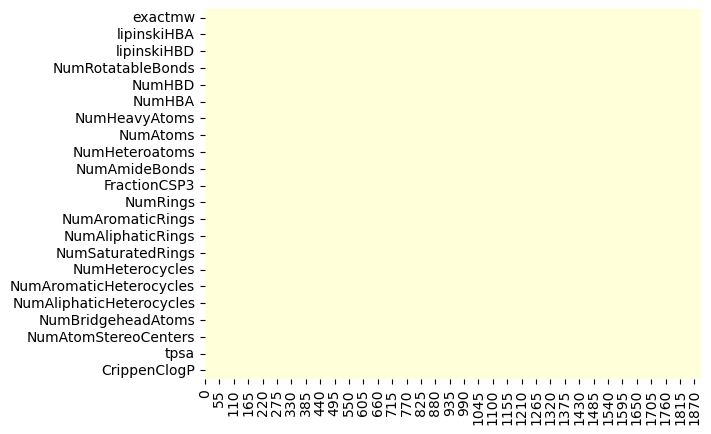

In [43]:
sns.heatmap(explanatory_variables.isna().transpose(), cmap='YlGnBu', cbar=False)
print(f"There are {explanatory_variables.isna().sum().sum()} NAs!")

# Zero variance filter

In [44]:
def get_non_zero_var(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [48]:
explanatory_variables_filter_var = get_non_zero_var(explanatory_variables)
print(explanatory_variables_filter_var.shape)
# Todas as variaveis foram mantidas, nenhuma tem pouca variância

(1895, 22)


Todas as variáveis foram mantidas!

# Remove Highly correlated features

In [55]:
def remove_high_corr(df, corr_threshold):
    corr_matrix = df.corr().abs()

    # Selecting only upper triangle
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

    remove = []

    for col in corr_matrix.columns:
        if any(corr_matrix[col] > corr_threshold):
            remove.append(col)
    print(f"Number of features removed: {len(remove)}")
    return df.drop(remove, axis=1)
    

<Axes: >

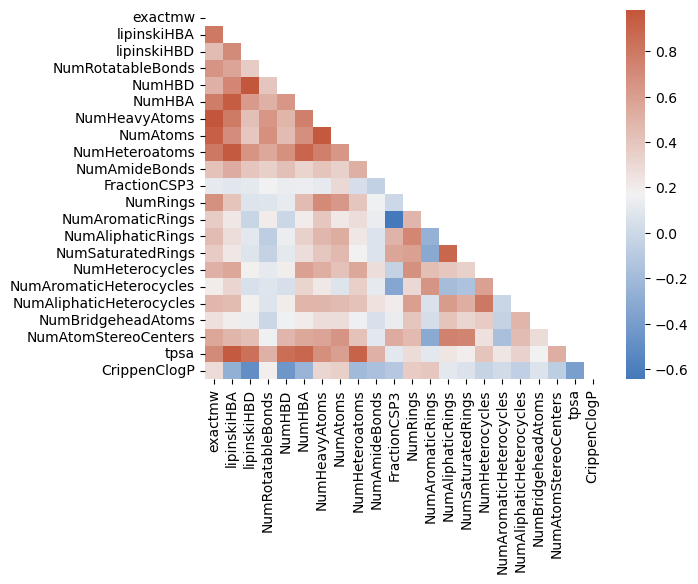

In [56]:
corr = explanatory_variables_filter_var.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(250, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap)

In [57]:
explanatory_variables_no_high_corr = remove_high_corr(explanatory_variables_filter_var, corr_threshold=0.93)
explanatory_variables_no_high_corr

Number of features removed: 6


,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,59.048347,3.0,5.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16143
1,75.032028,3.0,2.0,0.0,1.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.48830
2,76.027277,4.0,4.0,0.0,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.95610
3,77.029920,1.0,2.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12510
4,78.013936,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,1414.518432,38.0,25.0,35.0,8.0,0.618182,6.0,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,-7.70358
1891,1447.430200,33.0,21.0,13.0,7.0,0.424242,12.0,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,0.10620
1892,1638.627902,44.0,23.0,44.0,11.0,0.810345,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,-8.06040
1893,1753.637429,38.0,24.0,30.0,7.0,0.525000,12.0,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,2.69220


After removing correlated variables:

<Axes: >

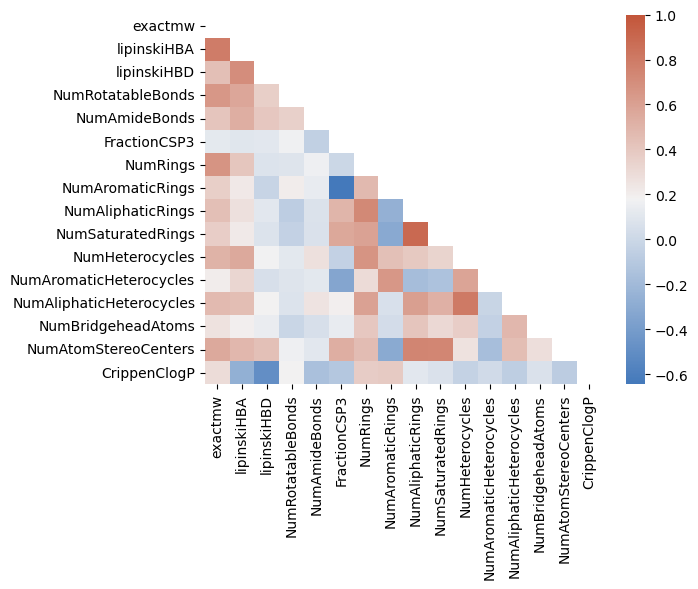

In [58]:
d = explanatory_variables_no_high_corr.corr()
mask = np.triu(np.ones_like(d, dtype=bool))
sns.heatmap(d, mask=mask, cmap=cmap, vmax=1)

In [59]:
explanatory_variables_no_high_corr

,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,59.048347,3.0,5.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16143
1,75.032028,3.0,2.0,0.0,1.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.48830
2,76.027277,4.0,4.0,0.0,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.95610
3,77.029920,1.0,2.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12510
4,78.013936,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,1414.518432,38.0,25.0,35.0,8.0,0.618182,6.0,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,-7.70358
1891,1447.430200,33.0,21.0,13.0,7.0,0.424242,12.0,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,0.10620
1892,1638.627902,44.0,23.0,44.0,11.0,0.810345,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,-8.06040
1893,1753.637429,38.0,24.0,30.0,7.0,0.525000,12.0,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,2.69220


# Re-join response and explanatory variables


In [60]:
drugs_processed = pd.concat([response_variables, explanatory_variables_no_high_corr], axis=1)
print(drugs_processed.shape)
drugs_processed

(1895, 30)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16143
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.48830
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.95610
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12510
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,...,6.0,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,-7.70358
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,12.0,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,0.10620
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,-8.06040
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,12.0,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,2.69220


# Saving

In [61]:
drugs_processed.to_csv("/home/gustavo/github/mestrado/reworks/models/oral_vs_non_oral/data/fda_heuristics_preprocessed.csv", index=False)